---
title: Replication Study
author: Andrew Dean
date: '2025-03-12'
image: "replication.gif"
description: "Replicates the analysis of Obermeyer et al. (2019) on the effect of race on healthcare costs."
code-fold: true
execute:
    warning: false
    message: false
---

## Abstract

In this replication study, I examine the findings of Obermeyer et al. (2019) in their paper "Dissecting Racial Bias in an Algorithm Used to Manage the Health of Populations." Their research investigates potential racial bias in healthcare algorithms that identify high-risk patients for additional support services. My analysis reproduces key figures from their work that demonstrate disparities between Black and White patients in risk score assignment and program eligibility. Specifically, I recreate visualizations showing the relationship between risk scores, chronic condition burden, and healthcare costs across racial groups. Additionally, I conduct a linear regression analysis to quantify the healthcare cost differential between Black and White patients with comparable health status. Finally, I discuss the implications of these disparities through the lens of algorithmic fairness principles, identifying which fairness criteria are violated by the observed patterns.

In [45]:
import pandas as pd
url = "https://gitlab.com/labsysmed/dissecting-bias/-/raw/master/data/data_new.csv?inline=false"
df = pd.read_csv(url)
df.head()

,risk_score_t,program_enrolled_t,cost_t,cost_avoidable_t,bps_mean_t,ghba1c_mean_t,hct_mean_t,cre_mean_t,ldl_mean_t,race,...,trig_min-high_tm1,trig_min-normal_tm1,trig_mean-low_tm1,trig_mean-high_tm1,trig_mean-normal_tm1,trig_max-low_tm1,trig_max-high_tm1,trig_max-normal_tm1,gagne_sum_tm1,gagne_sum_t
0,1.987430,0,1200.0,0.0,NaN,5.4,NaN,1.110000,194.0,white,...,0,0,0,0,0,0,0,0,0,0
1,7.677934,0,2600.0,0.0,119.0,5.5,40.4,0.860000,93.0,white,...,0,1,0,0,1,0,0,1,4,3
2,0.407678,0,500.0,0.0,NaN,NaN,NaN,NaN,NaN,white,...,0,0,0,0,0,0,0,0,0,0
3,0.798369,0,1300.0,0.0,117.0,NaN,NaN,NaN,NaN,white,...,0,0,0,0,0,0,0,0,0,0
4,17.513165,0,1100.0,0.0,116.0,NaN,34.1,1.303333,53.0,white,...,0,0,0,0,0,0,0,0,1,1


In [46]:
df_copy = df[["risk_score_t", "cost_t", "race", "gagne_sum_t"]].copy()
df_copy.head()

,risk_score_t,cost_t,race,gagne_sum_t
0,1.987430,1200.0,white,0
1,7.677934,2600.0,white,3
2,0.407678,500.0,white,0
3,0.798369,1300.0,white,0
4,17.513165,1100.0,white,1


## Reproduction of Figure 1: Percentile Risk Score vs. Mean Number of Chronic Illnesses

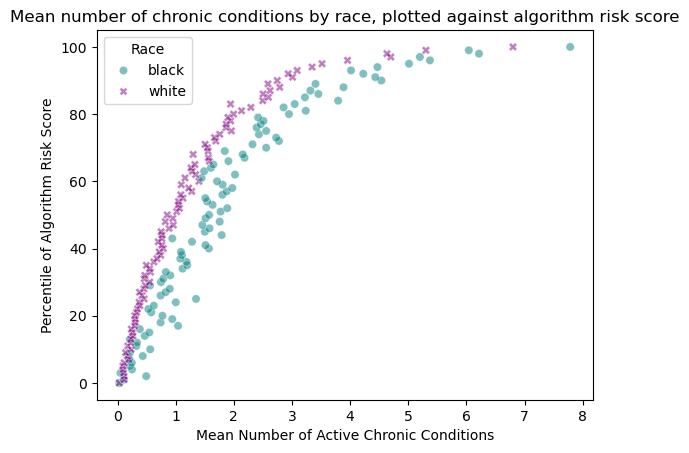

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

df_copy['risk_percentile'] = round(df_copy['risk_score_t'].rank(pct = True), 2) * 100

grouped_data = df_copy.groupby(['risk_percentile', 'race'])['gagne_sum_t'].mean()

grouped_data = pd.DataFrame(grouped_data)

# Use both hue and style parameters to control color and marker shape
sns.scatterplot(data=grouped_data, x='gagne_sum_t', y='risk_percentile', 
                hue='race', style='race',
                markers={'white': 'X', 'black': 'o'},
                palette={'white': 'purple', 'black': 'teal'},
                alpha=0.5)

plt.xlabel('Mean Number of Active Chronic Conditions')
plt.ylabel('Percentile of Algorithm Risk Score')
plt.title('Mean number of chronic conditions by race, plotted against algorithm risk score')

plt.legend(title='Race')

This plot begins to show some underlying racial bias that could be present within the algorithm. The white patients' curve of percentile risk score is higher than the black patients' curve. This suggests that less sick white patients are more likely to be referred to a high-risk program than sicker black patients.


### Reproduction of Figure 3: Costs versus algorithm-predicted risk, and costs versus health, by race.

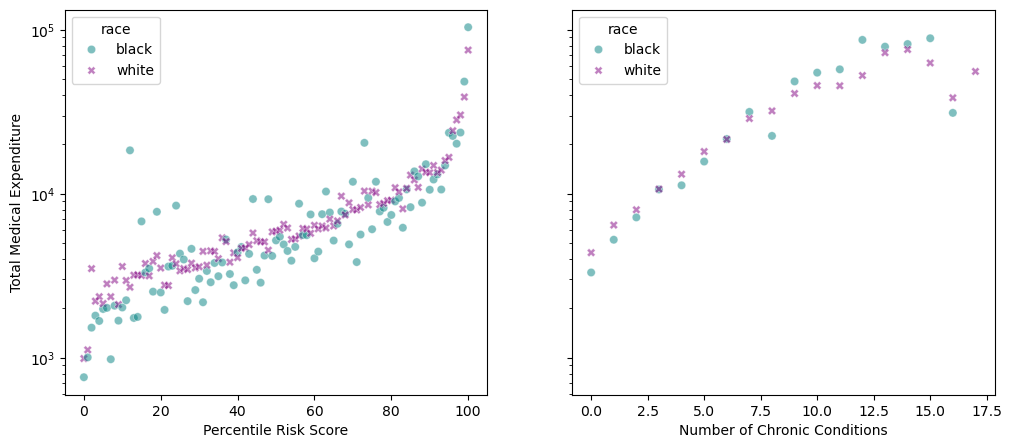

In [48]:
fig, axes = plt.subplots(1, 2, sharey = True, figsize = (12, 5))

cost_data = pd.DataFrame(df_copy.groupby(['risk_percentile', 'race'])['cost_t'].mean())
illness_data = pd.DataFrame(df_copy.groupby(['gagne_sum_t', 'race'])['cost_t'].mean())

sns.scatterplot(ax = axes[0], data=cost_data, x='risk_percentile', y='cost_t', hue='race', style='race', markers={'white': 'X', 'black': 'o'}, palette={'white': 'purple', 'black': 'teal'}, alpha=0.5)
sns.scatterplot(ax = axes[1], data=illness_data, x='gagne_sum_t', y='cost_t', hue='race', style='race', markers={'white': 'X', 'black': 'o'}, palette={'white': 'purple', 'black': 'teal'}, alpha=0.5)

axes[0].set_ylabel('Total Medical Expenditure')
axes[0].set_xlabel('Percentile Risk Score')
axes[1].set_xlabel('Number of Chronic Conditions')

plt.yscale("log")

This visualization reveals a clear racial disparity in healthcare costs. At equivalent levels of either risk score or chronic illness burden, Black patients consistently incur lower medical expenditures than White patients. This cost differential persists across most of the distribution, though the relationship becomes more volatile at the extreme right of both graphs where sample sizes diminish.

### Modeling Cost Disparity

There isn’t much data about patients with 5 or less chronic illnesses. Thus, let's limit the dataset to only patients with 5 or less chronic illnesses to prevent outliers.

In [49]:
more_than_5 = round((df_copy['gagne_sum_t'] >= 5).mean() * 100, 2)
more_than_5

7.0

Since 93% of patients in this dataset have 5 or fewer chronic conditions, focusing on this majority group provides a reasonable choice for analysis. While examining trends for patients with higher chronic illness burdens remains important, limiting our scope to this predominant group helps avoid potential misinterpretations from sparse data. This approach ensures our analysis captures the most representative patterns while acknowledging the limitations of drawing conclusions about smaller subgroups with more complex conditions.

### Data Prep

Below I calculate the log cost. This is important because our target variable varies widely across several orders of magnitude.

In [50]:
import numpy as np

df_not_0 = df_copy.drop(df_copy[df_copy['cost_t'] == 0].index)
df_not_0['log_cost'] = np.log(df_not_0['cost_t'])

Next, I create dummy variables for the race column.

In [55]:
df_not_0 = pd.get_dummies(df_not_0)
df_not_0.head()

,risk_score_t,cost_t,gagne_sum_t,risk_percentile,log_cost,race_black,race_white
0,1.987430,1200.0,0,35.0,7.090077,False,True
1,7.677934,2600.0,3,86.0,7.863267,False,True
2,0.407678,500.0,0,4.0,6.214608,False,True
3,0.798369,1300.0,0,11.0,7.170120,False,True
4,17.513165,1100.0,1,98.0,7.003065,False,True


In [52]:
X_train = df_not_0[['gagne_sum_t', 'race_black']].rename(columns={'race_black' : 'race'})
y_train = df_not_0[['log_cost']]

## Model: Logistic Regression

In [53]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

LR = LinearRegression()
LR.fit(X_train, y_train)

def add_polynomial_features(X, degree):
  X_ = X.copy()
  for j in range(1, degree):
    X_[f"poly_{j}"] = X_["gagne_sum_t"]**j
  return X_

Let's now use cross validation to see how many polynomial features are best.

In [ ]:
from sklearn.linear_model import Ridge
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
import warnings

poly_degrees = range(1, 12)  # From 1 to 11
alphas = [10**k for k in range(-4, 5)]  # 10^-4 to 10^4

results_list = []

# Loop through polynomial degrees and regularization strengths
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    for degree in poly_degrees:
        for alpha in alphas:
            # Add polynomial features
            X_deg = add_polynomial_features(X_train, degree)
            
            # Create and fit Ridge regression model
            ridge = Ridge(alpha=alpha)
            
            # Calculate cross-validation score
            cv_score = cross_val_score(ridge, X_deg, y_train, cv=5, 
                                      scoring='neg_mean_squared_error').mean()
            
            results_list.append({
                'poly_degree': degree,
                'alpha': alpha,
                'cv_score': cv_score
            })

results = pd.DataFrame(results_list)

# Find the best combination (highest score = lowest MSE since scores are negative)
best_result = results.loc[results['cv_score'].idxmax()]
print(f"Best polynomial degree: {best_result['poly_degree']}")
print(f"Best alpha: {best_result['alpha']}")
print(f"Best CV score (negative MSE): {best_result['cv_score']}")

# Find the best model
best_X = add_polynomial_features(X_train, int(best_result['poly_degree']))
best_model = Ridge(alpha=best_result['alpha'])
best_model.fit(best_X, y_train)

w_ridge = best_model.coef_
print("Model coefficients:")
print(w_ridge)

# Extract the coefficient for race
coef_b = w_ridge[1]
print(f"Coefficient for race: {coef_b}")

# Calculate the cost incurred by Black patients as a percentage of White patients
cost_incurred_b = np.exp(coef_b)
print(f"Cost incurred by Black patients as percentage of White patients: {cost_incurred_b:.2%}")

Best polynomial degree: 10.0
Best alpha: 1.0
Best CV score (negative MSE): -1.5084341103486478
Model coefficients:
[ 4.96332019e-01 -2.67045509e-01  4.96332015e-01 -9.84047253e-01
  5.56357271e-01 -1.66928757e-01  2.91396071e-02 -3.04865853e-03
  1.87779882e-04 -6.26253079e-06  8.70642175e-08]
Coefficient for race: -0.2670455094431721
Cost incurred by Black patients as percentage of White patients: 76.56%


/opt/anaconda3/envs/ml-0451/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=1.74738e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


The code above performs a comprehensive search for the best model. I test different polynomial degrees (1-11) and regularization strengths (10^-4 to 10^4) using cross-validation to find the optimal combination that minimizes prediction error. After identifying the best model parameters, I fit the final model and extract the coefficient for race, which reveals how much less Black patients cost compared to White patients with equivalent health status.

The coefficients correspond to the order of features in our input data. The second coefficient represents the effect of race (race_black). This value can be interpreted as the estimated percentage difference in costs between Black patients and White patients, controlling for health status. This value can be interpreted as the estimated percentage difference in costs between Black patients and White patients, controlling for health status

The coefficient indicates that Black patients incur approximately 76.56% of the healthcare costs of White patients with equivalent health status. This finding aligns with the core argument presented by Obermeyer et al. (2019), though my analysis reveals a somewhat larger racial disparity in healthcare expenditures than documented in the original paper. Nevertheless, both analyses consistently demonstrate that Black patients generate lower healthcare costs than White patients with comparable health conditions.

## Discussion

This replication study highlights the substantial effort required in data preparation and cleaning to achieve meaningful analytical results. The recreated Figure 1 demonstrates that white patients consistently receive higher algorithm risk scores than black patients with equivalent chronic illness burdens. This disparity creates a concerning situation where black patients are less frequently referred to beneficial high-risk care management programs despite similar health needs.

Figure 3 clearly illustrates that across most of the distribution—particularly at lower chronic illness counts where data is most abundant—white patients generate higher healthcare expenditures than black patients with comparable health conditions. The linear regression analysis quantifies this disparity, confirming the systematic cost differential between racial groups.

Of the formal statistical discrimination criteria discussed in Chapter 3 of Barocas, Hardt, and Narayanan (2023), which best describe the purported bias of the algorithm studied by Obermeyer et al. (2019)? What aspects of the study support your answer?


Of the formal statistical discrimination criteria discussed in Chapter 3 of Barocas, Hardt, and Narayanan (2023), the separation criterion (error rate balance) most clearly describes the algorithmic bias identified by Obermeyer et al. (2019). While the algorithm demonstrates similar relationships between risk scores and costs across racial groups, it systematically assigns higher risk percentile scores to white patients compared to black patients with equivalent health conditions. This creates an imbalance in error rates, as Obermeyer et al. explicitly note that the algorithm incorrectly concludes that "black patients are healthier than equally sick white patients." This disparity in risk assessment directly impacts healthcare access, with the algorithm effectively imposing a higher threshold for black patients to qualify for additional care programs despite similar underlying health needs.